In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

2023-05-16 01:08:35.194954: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def generate_test_data(test_df, image_type_path):
    clahe=cv2.createCLAHE(clipLimit=50)
    labels = []
    images = []
    for image_path, label in test_df[[image_type_path, "pathology"]].values:
        if image_path == "no":
            pass
        else:
            if label == "BENIGN":
                labels.append(0)
            else:
                labels.append(1)
            # labels.append(label)
            image = cv2.imread(image_path)
            image = tf.image.resize(image, (299, 299)).numpy().astype("uint8")
            images.append(image)
    return np.array(images), np.array(labels)

In [4]:
train = pd.read_csv("../CBIS-DDSM/csv/calc_train_updated.csv", index_col=0)
test = pd.read_csv("../CBIS-DDSM/csv/calc_test_updated.csv", index_col=0)

In [7]:
BATCH_SIZE = 256
IMG_SIZE = 299
new_dataset_train_path = "../image_dataset/calc_dataset/full_images/train/"
new_dataset_val_path = "../image_dataset/calc_dataset/full_images/validation/"
new_dataset_test_path = "../image_dataset/calc_dataset/full_images/test/"

tf_train_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(299, 299))

tf_validation_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_val_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

tf_test_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_test_path,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                   image_size=(299, 299))

images, labels = generate_test_data(test, image_type_path="image file path")

Found 1072 files belonging to 2 classes.
Found 215 files belonging to 2 classes.
Found 41 files belonging to 2 classes.


2023-05-16 02:10:48.541206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [215]
	 [[{{node Placeholder/_4}}]]
2023-05-16 02:10:48.543146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [215]
	 [[{{node Placeholder/_4}}]]


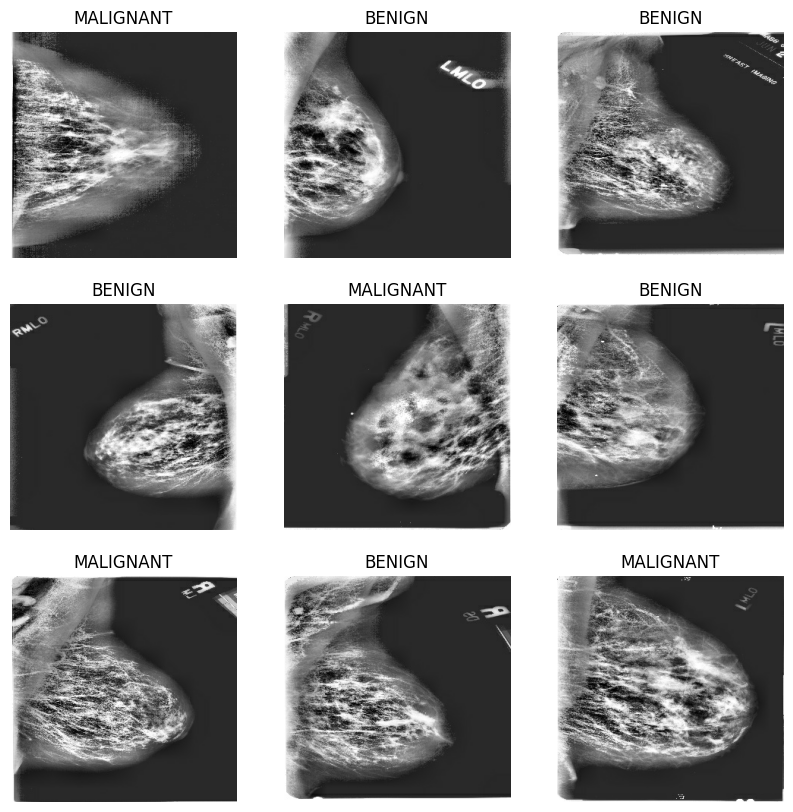

In [13]:
class_names = tf_train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in tf_validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras. layers.RandomFlip("horizontal_and_vertical")])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [9]:
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                               input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs, x)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218752 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              104960

In [11]:
history = model.fit(tf_train_dataset,
                    epochs=40,
                    batch_size=256,
                    validation_data=tf_test_dataset)

new_dataset_test_path = "../image_dataset/mass_dataset/full_images/test/"


tf_test_dataset = tf.keras.utils.image_dataset_from_directory(new_dataset_test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                              image_size=(299, 299))

mets = model.evaluate(tf_test_dataset)
print("loss:", mets[0], "\naccuracy:", np.round(mets[1]*100, 4), "%")

Epoch 1/40


2023-05-16 01:09:19.096359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1072]
	 [[{{node Placeholder/_4}}]]
2023-05-16 01:09:19.110863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1072]
	 [[{{node Placeholder/_0}}]]
2023-05-16 01:09:21.631600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - ETA: 0s - loss: 320.2664 - accuracy: 0.5103

2023-05-16 01:09:51.830002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [41]
	 [[{{node Placeholder/_4}}]]
2023-05-16 01:09:51.831256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [41]
	 [[{{node Placeholder/_4}}]]
2023-05-16 01:09:52.559553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 35s 6s/step - loss: 320.2664 - accuracy: 0.5103 - val_loss: 1.1197 - val_accuracy: 0.6829
Epoch 2/40
5/5 [==============================] - 29s 5s/step - loss: 14.1845 - accuracy: 0.5215 - val_loss: 3.9173 - val_accuracy: 0.3415
Epoch 3/40
5/5 [==============================] - 31s 6s/step - loss: 2.5089 - accuracy: 0.4981 - val_loss: 0.6936 - val_accuracy: 0.5854
Epoch 4/40
5/5 [==============================] - 30s 5s/step - loss: 1.2356 - accuracy: 0.4953 - val_loss: 0.6927 - val_accuracy: 0.6585
Epoch 5/40
5/5 [==============================] - 33s 6s/step - loss: 0.7682 - accuracy: 0.5075 - val_loss: 0.6927 - val_accuracy: 0.6585
Epoch 6/40
5/5 [==============================] - 29s 5s/step - loss: 0.7116 - accuracy: 0.4897 - val_loss: 0.6928 - val_accuracy: 0.6585
Epoch 7/40
5/5 [==============================] - 32s 6s/step - loss: 0.7023 - accuracy: 0.5252 - val_loss: 0.6928 - val_accuracy: 0.6585
Epoch 8/40
5/5 [==========================

KeyboardInterrupt: 

In [12]:
y_pred = model.predict(tf_test_dataset)

print(classification_report(y_true=labels, y_pred=np.round(np.squeeze(y_pred))))

2023-05-16 01:15:45.803078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.66      1.00      0.79        27

    accuracy                           0.66        41
   macro avg       0.33      0.50      0.40        41
weighted avg       0.43      0.66      0.52        41



/Users/kaushik/Documents/Thesis_line_detection/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kaushik/Documents/Thesis_line_detection/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kaushik/Documents/Thesis_line_detection/.env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

In [25]:
import plotly.express as px

In [34]:
confusion_matrix(labels, np.round(np.squeeze(y_pred))) 

array([[ 90, 104],
       [ 71,  76]])

In [38]:
90 104 

194

# 71 +76

In [35]:
tf_test_dataset.class_names

['BENIGN', 'MALIGNANT']

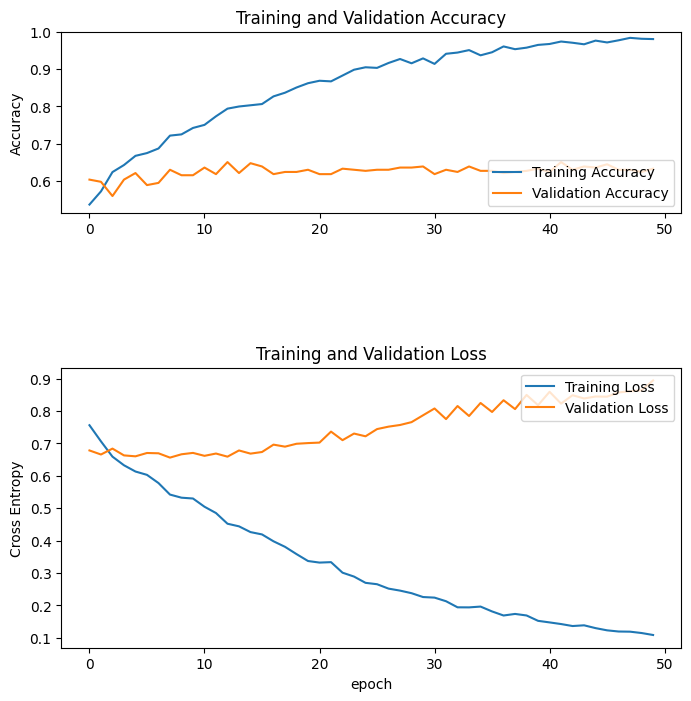

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()